<a href="https://colab.research.google.com/github/prudhvi260/QA-Chatbot/blob/main/QA_ChatBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import numpy as np
import pickle

In [ ]:
with open('/content/test_qa.txt','rb') as f:
  test_qa = pickle.load(f)
with open('/content/train_qa.txt','rb') as f:
  train_qa = pickle.load(f)
print(train_qa[0]) # tuple contains story,question,answer
print(test_qa[0])  # tuple contains story,question,answer
print(' '.join(train_qa[0][0]))

print(len(train_qa))
print(len(test_qa))

all_data = train_qa + test_qa
print(len(all_data))

vocab = set()

for story,question,answer in train_qa + test_qa:
  vocab = vocab.union(set(story))
  vocab = vocab.union(set(question))
vocab.add('no')
vocab.add('yes')
print(vocab)
print(len(vocab))
vocab_len = len(vocab) + 1

max_story_len = max([len(data[0]) for data in all_data])
max_question_len = max([len(data[1]) for data in all_data])
print(max_story_len)
print(max_question_len)


#################### Vectorize the Data #########################


from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

toknizer = Tokenizer(filters=[])
toknizer.fit_on_texts(vocab)
print(toknizer.word_index)

def vectorize_stories(data,word_index=toknizer.word_index,max_story_len=max_story_len,max_question_len=max_question_len):

    '''
    INPUT:

    data: consisting of Stories,Queries,and Answers
    word_index: word index dictionary from tokenizer
    max_story_len: the length of the longest story (used for pad_sequences function)
    max_question_len: length of the longest question (used for pad_sequences function)


    OUTPUT:

    Vectorizes the stories,questions, and answers into padded sequences. We first loop for every story, query , and
    answer in the data. Then we convert the raw words to an word index value. Then we append each set to their appropriate
    output list. Then once we have converted the words to numbers, we pad the sequences so they are all of equal length.

    Returns this in the form of a tuple (X,Xq,Y) (padded based on max lengths)
    '''
    #stories
    X=[]
    # storyQuestions
    XQ =[]
    #answers
    Y=[]

    for story,questio,answer in data:
      X.append([word_index[word.lower()] for word in story])
      XQ.append([word_index[word.lower()] for word in questio])
      y = np.zeros(len(word_index) + 1)
      y[word_index[answer]] = 1
      Y.append(y)
    return (pad_sequences(X,maxlen=max_story_len),pad_sequences(XQ,maxlen=max_question_len),np.array(Y))

inputs_train, queries_train, answers_train = vectorize_stories(train_qa)
inputs_test, queries_test, answers_test = vectorize_stories(test_qa)

print(inputs_train)
print(inputs_test)
print(queries_train)
print(queries_test)

sum(answers_test)


##############################  Model Building  ############################

from keras.models import Sequential, Model
from keras.layers import Embedding, Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM

input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_len,output_dim=64))
input_encoder_m.add(Dropout(0.3))

input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_len,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_len,output_dim=64,input_length=max_question_len))
question_encoder.add(Dropout(0.3))

input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

match = dot([input_encoded_m,question_encoded],axes=(2,2))
match = Activation('softmax')(match)

response = add([match,input_encoded_c])
response = Permute((2,1))(response)

answer = concatenate([response,question_encoded])

print(answer)

answer = LSTM(32)(answer)
answer = Dropout(0.5)(answer)
answer = Dense(vocab_len)(answer)
answer = Activation('softmax')(answer)

model = Model([input_sequence,question],answer)
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()


######################## Fit And Train Model And Test #########################

history = model.fit([inputs_train,queries_train],answers_train,batch_size=32,epochs=120,validation_data=([inputs_test,queries_test],answers_test))

model.save('my_model.h5')





(['Mary', 'moved', 'to', 'the', 'bathroom', '.', 'Sandra', 'journeyed', 'to', 'the', 'bedroom', '.'], ['Is', 'Sandra', 'in', 'the', 'hallway', '?'], 'no')
(['Mary', 'got', 'the', 'milk', 'there', '.', 'John', 'moved', 'to', 'the', 'bedroom', '.'], ['Is', 'John', 'in', 'the', 'kitchen', '?'], 'no')
Mary moved to the bathroom . Sandra journeyed to the bedroom .
10000
1000
11000
{'took', 'John', 'put', 'hallway', 'Daniel', 'in', 'left', 'back', 'bedroom', 'to', 'Sandra', 'journeyed', 'up', 'travelled', 'Is', 'grabbed', 'no', 'the', 'milk', 'apple', 'discarded', 'down', 'office', 'football', 'picked', 'went', 'moved', 'got', 'dropped', 'yes', 'garden', 'Mary', 'kitchen', 'there', '.', '?', 'bathroom'}
37
156
6
{'took': 1, 'john': 2, 'put': 3, 'hallway': 4, 'daniel': 5, 'in': 6, 'left': 7, 'back': 8, 'bedroom': 9, 'to': 10, 'sandra': 11, 'journeyed': 12, 'up': 13, 'travelled': 14, 'is': 15, 'grabbed': 16, 'no': 17, 'the': 18, 'milk': 19, 'apple': 20, 'discarded': 21, 'down': 22, 'office': 2

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25            │ (None, 156)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_26            │ (None, 6)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_15             │ (None, 156, 64)        │          2,432 │ input_layer_25[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_17             │ (None, 6, 64)          │          2,432 │ input_layer_26[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot_5 (Dot)               │ (None, 156, 6)         │              0 │ sequential_15[0][0],   │
│                           │                        │                │ sequential_17[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_10             │ (None, 156, 6)         │              0 │ dot_5[0][0]            │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_16             │ (None, 156, 6)         │            228 │ input_layer_25[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 156, 6)         │              0 │ activation_10[0][0],   │
│                           │                        │                │ sequential_16[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ permute_5 (Permute)       │ (None, 6, 156)         │              0 │ add_5[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 6, 220)         │              0 │ permute_5[0][0],       │
│ (Concatenate)             │                        │                │ sequential_17[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 32)             │         32,384 │ concatenate_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_23 (Dropout)      │ (None, 32)             │              0 │ lstm_5[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 38)             │          1,254 │ dropout_23[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_11             │ (None, 38)             │              0 │ dense_5[0][0]          │
│ (Activation)              │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,730 (151.29 KB)

 Trainable params: 38,730 (151.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/120
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.4837 - loss: 1.2741 - val_accuracy: 0.5030 - val_loss: 0.6947
Epoch 2/120
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.5117 - loss: 0.7096 - val_accuracy: 0.4970 - val_loss: 0.6941
Epoch 3/120
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.4940 - loss: 0.7007 - val_accuracy: 0.5030 - val_loss: 0.6948
Epoch 4/120
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4989 - loss: 0.6962 - val_accuracy: 0.4970 - val_loss: 0.6933
Epoch 5/120
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5061 - loss: 0.6950 - val_accuracy: 0.5030 - val_loss: 0.6936
Epoch 6/120
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.4993 - loss: 0.6957 - val_accuracy: 0.5030 - val_loss: 0.6940
Epoch 7/120
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.5080 - loss: 0.6957 - val_accuracy: 0.5030 - val_loss: 0.6932
Epoch 8/120
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.5040 - loss: 0.6946 -

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


KeyError: 'acc'

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


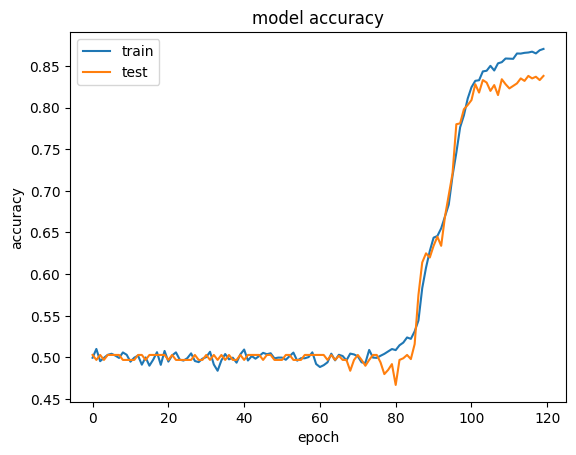

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted answer is:  yes
Probability of certainty was:  0.96774274


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

model.load_weights('/content/my_model.h5')
pred_results = model.predict(([inputs_test, queries_test]))


my_story = "John left the kitchen . Sandra dropped the football in the garden ."
my_story.split()
my_question = "Is the football in the garden ?"
my_question.split()
mydata = [(my_story.split(),my_question.split(),'yes')]

my_story,my_ques,my_ans = vectorize_stories(mydata)
pred_results = model.predict(([ my_story, my_ques]))
val_max = np.argmax(pred_results[0])

for key,val in toknizer.word_index.items():
    if val == val_max:
        k = key
print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

In [ ]:
!pip install --upgrade tensorflow keras


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
